## Lending Club Case Study

Madison Hawkinson

In [1610]:
import numpy as np
import pandas as pd
import seaborn as sns
import dateutil.parser as parse
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler 
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_classification
from sklearn.metrics import f1_score, classification_report, log_loss
from sklearn.linear_model import LinearRegression
import math  
pd.set_option('display.max_colwidth', -1)
import warnings
warnings.filterwarnings('ignore')
pal = sns.color_palette("Blues_r")

## Part 0: Lending Club Loan Data

Overview: "These files contain complete loan data for all loans issued through the 2007-2015, including the current loan status (Current, Late, Fully Paid, etc.) and latest payment information. The file containing loan data through the "present" contains complete loan data for all loans issued through the previous completed calendar quarter. Additional features include credit scores, number of finance inquiries, address including zip codes, and state, and collections among others. The file is a matrix of about 890 thousand observations and 75 variables. A data dictionary is provided in a separate file."
https://www.kaggle.com/wendykan/lending-club-loan-data

## Part 0: Function Definition

In [1387]:
# get_data requires inputs of desired columns, the file string, file type (excel or csv), and whether to transform the data
# output is a dataframe 
def get_data(columns, file, file_type='csv', transform=False):
    if file_type=='csv':
        data = pd.read_csv(file)
    elif file_type=='excel': 
        data = pd.read_excel(file) 
        data=data.fillna('')
        if transform: 
            data = pd.DataFrame(data.T.rename(columns=data.T.iloc[0]).iloc[1]).T
    return data[columns]

In [1388]:
# parses a string to generate a year using parser pkg 
def get_year(string_year):
    year = parser.parse(string_year).year
    return year

In [1389]:
# uses parser function to iterate extract years for entire dataframe and build new column
def get_all_years(data):
    data['year']=0
    for index,row in data.iterrows():
        year = get_year(row.issue_d)
        data.set_value(index, 'year', year)
    return data

In [1390]:
# function calculates annualized rate of return 
def calculate_ror(total_pymnt, funded_amnt):
    ror = ((total_pymnt/funded_amnt)**(1/3))-1
    return ror

In [1391]:
# iterates over entire dataframe to calculate all rate of returns
def get_all_rors(data):
    data['annualized_rate_of_return']=0.0
    for index,row in data.iterrows():
        ror = calculate_ror(row.total_pymnt, row.funded_amnt)
        data.set_value(index, 'annualized_rate_of_return', ror)
    return data

In [1392]:
# winsorizes a column in a dataframe given the percentiles desired
def winsorize_data(data, col, p_lower, p_upper):
    quantiles = loan_data[col].quantile([p_lower, p_upper])
    q_lower = quantiles.loc[p_lower]
    q_upper = quantiles.loc[p_upper]
    data[col] = data[col].clip(lower=q_lower, upper=q_upper)
    return data

In [1523]:
# fit linear regression model
def fit_lin_reg(data, feature, label='default_label', one_hot=True):
    x_feature = loan_data_36_months[feature]
    if one_hot: 
        x_feature = pd.get_dummies(x_feature, columns=[feature])
    y_label = loan_data_36_months[label]
    linreg = LinearRegression()
    return linreg, x_feature, y_label

In [1521]:
# get r squared from linear regression model between two variables
def calculate_r_sq(data, feature, label='default_label', one_hot=True):
    linreg, x_feature, y_label = fit_lin_reg(data, feature, label, one_hot)
    linreg.fit(x_feature, y_label)
    r_sq = linreg.score(x_feature, y_label)
    return r_sq

In [1539]:
# calculate rmse as defined by: https://stackoverflow.com/questions/17197492/is-there-a-library-function-for-root-mean-square-error-rmse-in-python
def eval_rmse(preds, labels):
    n = len(preds)
    rmse = np.linalg.norm(preds - labels) / np.sqrt(n)
    return rmse

## Part 1: Data Exploration and Evaluation

In [511]:
columns=['loan_amnt', 
          'funded_amnt', 
          'term', 
          'int_rate', 
          'grade', 
          'annual_inc', 
          'issue_d',
          'dti', 
          'revol_bal', 
          'total_pymnt', 
          'loan_status']

In [72]:
loan_data_descriptions = get_data(columns, "LCDataDictionary.xlsx", 'excel', True)

In [118]:
loan_data_descriptions

,loan_amnt,funded_amnt,term,int_rate,grade,annual_inc,issue_d,dti,revol_bal,total_pymnt,loan_status
Description,"The listed amount of the loan applied for by the borrower. If at some point in time, the credit department reduces the loan amount, then it will be reflected in this value.",The total amount committed to that loan at that point in time.,The number of payments on the loan. Values are in months and can be either 36 or 60.,Interest Rate on the loan,LC assigned loan grade,The self-reported annual income provided by the borrower during registration.,The month which the loan was funded,"A ratio calculated using the borrower’s total monthly debt payments on the total debt obligations, excluding mortgage and the requested LC loan, divided by the borrower’s self-reported monthly income.",Total credit revolving balance,Payments received to date for total amount funded,Current status of the loan


In [913]:
loan_data = get_data(columns, "loan.csv")

In [915]:
loan_data.head()

,loan_amnt,funded_amnt,term,int_rate,grade,annual_inc,issue_d,dti,revol_bal,total_pymnt,loan_status
0,2500,2500,36 months,13.56,C,55000.0,Dec-2018,18.24,4341.0,167.02,Current
1,30000,30000,60 months,18.94,D,90000.0,Dec-2018,26.52,12315.0,1507.11,Current
2,5000,5000,36 months,17.97,D,59280.0,Dec-2018,10.51,4599.0,353.89,Current
3,4000,4000,36 months,18.94,D,92000.0,Dec-2018,16.74,5468.0,286.71,Current
4,30000,30000,60 months,16.14,C,57250.0,Dec-2018,26.35,829.0,1423.21,Current


### Summary Statistics

• Loan amount and funded amount appear to be nearly identical. 

• Interest rate appears to cleanly fit the reasonable range between 0-30% (due to Usury laws).  

• DTI has unreasonably high minimums and maximums for a rate, indicating outliers that should be processed. 

In [916]:
loan_data.describe(percentiles=[.01, .05, .1, .25, .5, .75, .9, .95, .99])

,loan_amnt,funded_amnt,int_rate,annual_inc,dti,revol_bal,total_pymnt
count,957840.000000,957840.000000,957840.000000,9.578390e+05,956643.000000,9.578390e+05,957839.000000
mean,15409.325696,15409.296464,12.857171,7.978386e+04,19.296447,1.660857e+04,9003.269381
std,9615.172240,9615.174353,5.029520,8.352798e+04,16.394262,2.333667e+04,9008.270675
min,1000.000000,1000.000000,1.000000,0.000000e+00,-1.000000,0.000000e+00,0.000000
1%,1500.000000,1500.000000,5.320000,1.533676e+04,1.550000,5.700000e+01,311.660000
5%,3200.000000,3200.000000,6.110000,2.700000e+04,4.750000,1.310000e+03,734.620000
10%,5000.000000,5000.000000,6.990000,3.400000e+04,7.130000,2.615000e+03,1134.240000
25%,8000.000000,8000.000000,9.160000,4.700000e+04,11.880000,5.657000e+03,2414.880000
50%,13000.000000,13000.000000,11.990000,6.600000e+04,17.990000,1.103400e+04,5779.360000
75%,20000.000000,20000.000000,15.590000,9.500000e+04,24.970000,1.999900e+04,12460.489701


### Cleaning Data

No duplicates exist.

In [932]:
loan_data[loan_data.duplicated()] 

,loan_amnt,funded_amnt,term,int_rate,grade,annual_inc,issue_d,dti,revol_bal,total_pymnt,loan_status


No obvious nulls/problematic columns in dataset.

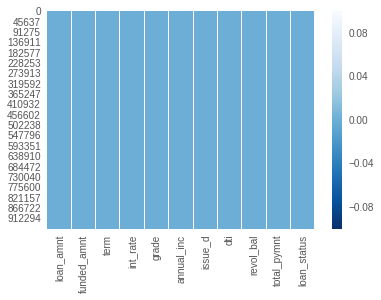

In [1355]:
sns.heatmap(loan_data.isnull(), cmap="Blues_r")

Evidence of one outlier with many nulls, can be removed since it's negligible. 

In [919]:
loan_data.isna().sum()

loan_amnt      0   
funded_amnt    0   
term           0   
int_rate       0   
grade          1   
annual_inc     1   
issue_d        1   
dti            1197
revol_bal      1   
total_pymnt    1   
loan_status    1   
dtype: int64

Because DTI rate nulls are only 1196/957840, we will remove these nulls. There is no clear replacement given DTI is a rate from 0->100%. 

In [920]:
loan_data = loan_data[loan_data.dti.isna()==False]

In [921]:
loan_data.isna().sum()

loan_amnt      0
funded_amnt    0
term           0
int_rate       0
grade          0
annual_inc     0
issue_d        0
dti            0
revol_bal      0
total_pymnt    0
loan_status    0
dtype: int64

### Features

There are three different feature data types, but they can be extracted down to categorical (object) and continuous (int and float).

In [1255]:
loan_data.dtypes

loan_amnt      int64  
funded_amnt    int64  
term           object 
int_rate       float64
grade          object 
annual_inc     float64
issue_d        object 
dti            float64
revol_bal      float64
total_pymnt    float64
loan_status    object 
dtype: object

In [923]:
feature_groups = loan_data.columns.to_series().groupby(loan_data.dtypes).groups
{k.name: v for k, v in feature_groups.items()}

{'int64': Index(['loan_amnt', 'funded_amnt'], dtype='object'),
 'float64': Index(['int_rate', 'annual_inc', 'dti', 'revol_bal', 'total_pymnt'], dtype='object'),
 'object': Index(['term', 'grade', 'issue_d', 'loan_status'], dtype='object')}

We iterate through the different feature types to get feature distributions, either across the range of the feature (continuous) or grouped by category (categorical). 

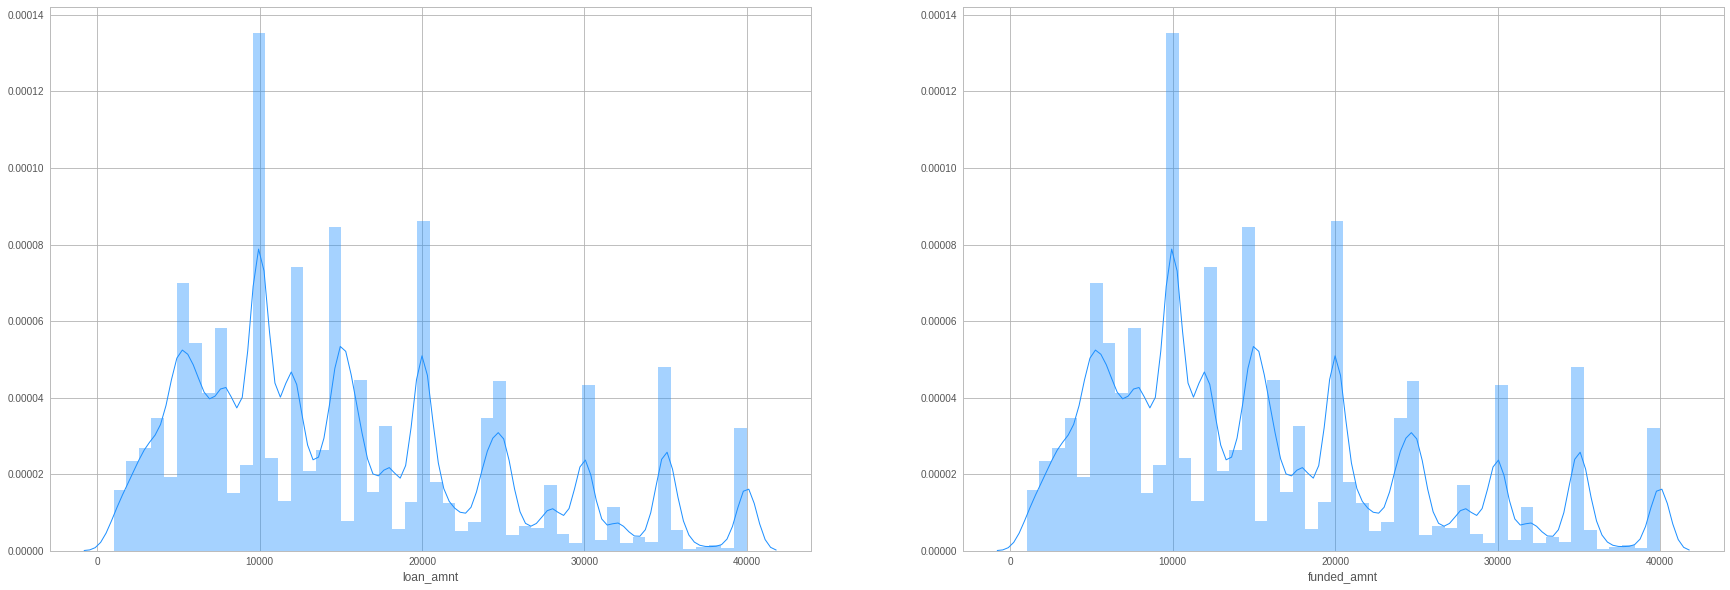

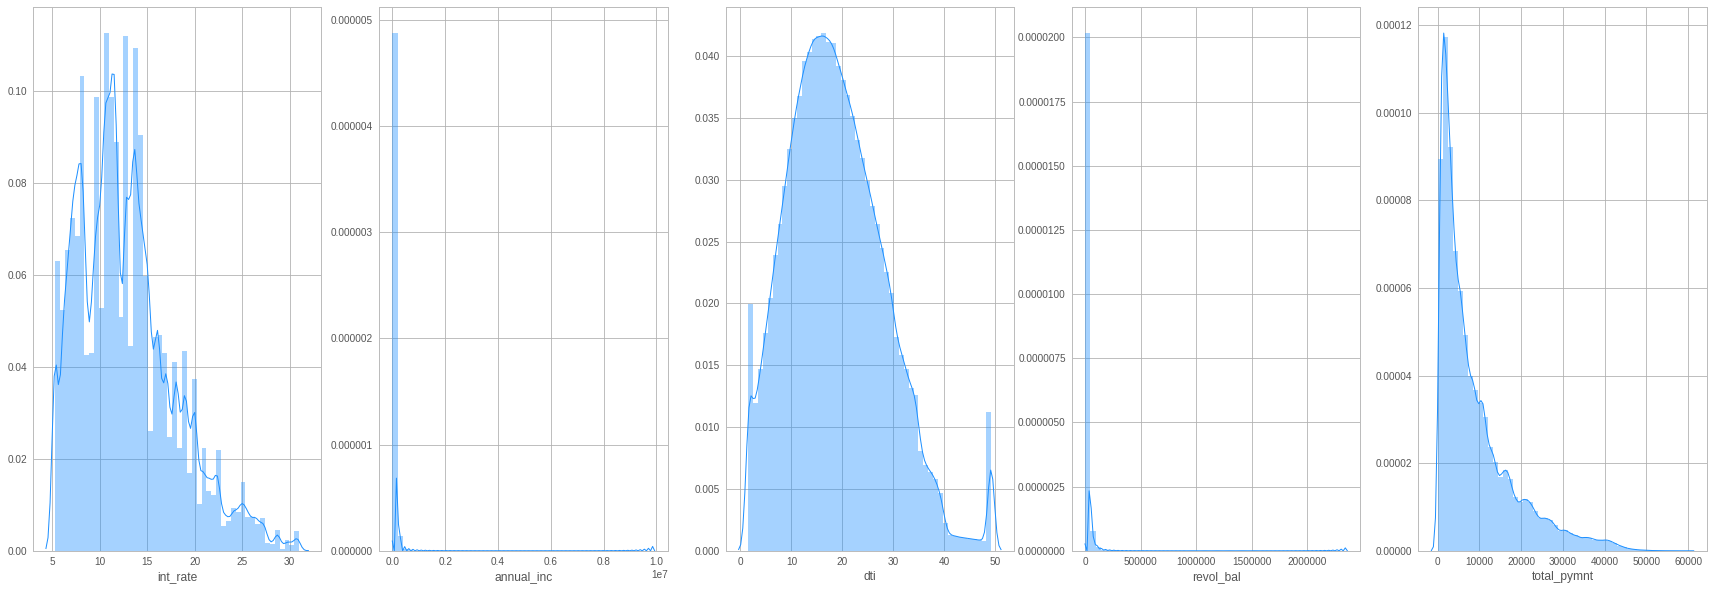

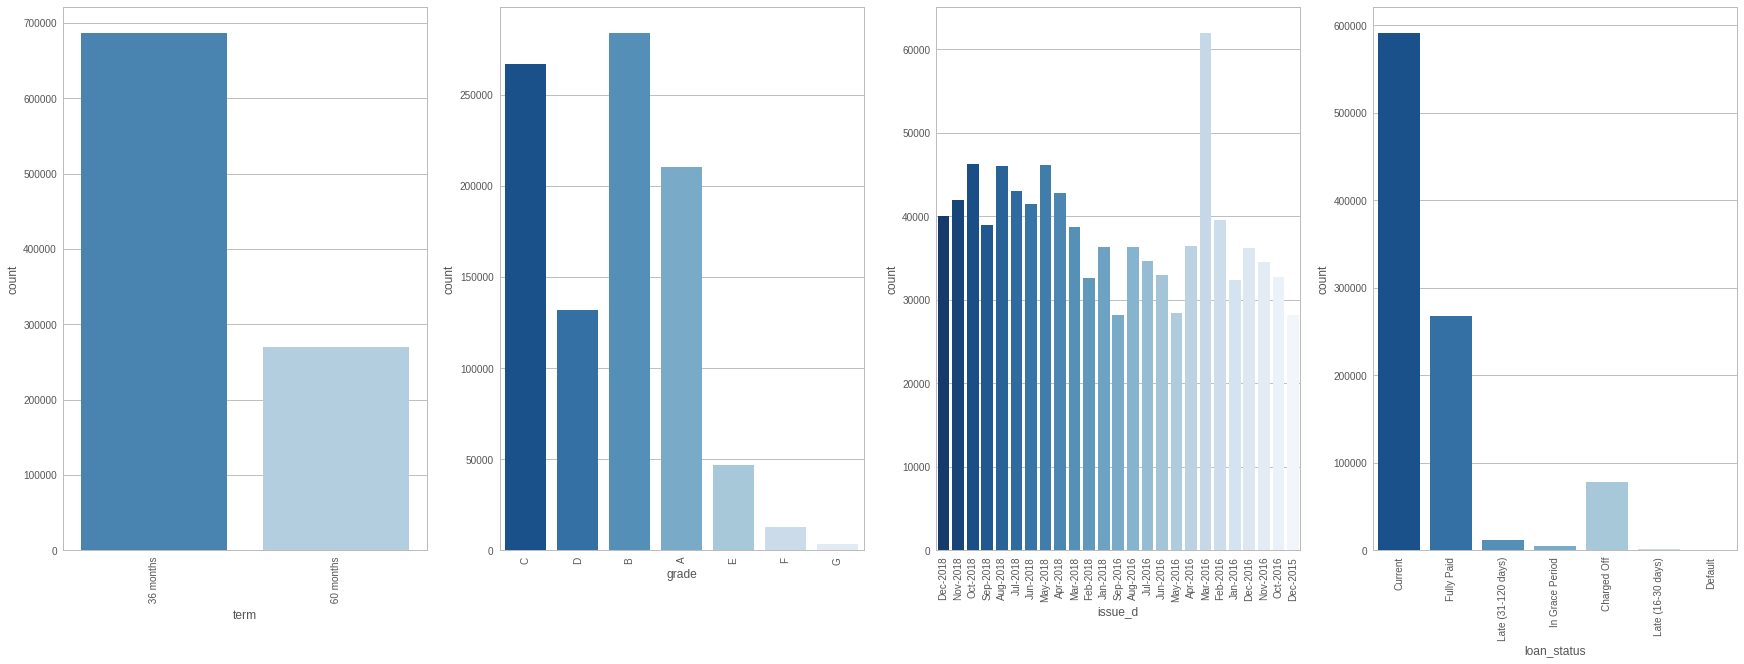

In [1386]:
for item in feature_groups:
    fig, ax = plt.subplots(1, len(feature_groups[item]), figsize=(30, 10))
    for feature, subplot in zip(feature_groups[item], ax.flatten()): 
        if item=='int64' or item=='float64':
            sns.distplot(loan_data[feature_groups[item]][feature], ax=subplot, color="dodgerblue")
        elif item=='object':
            sns.countplot(loan_data[feature_groups[item]][feature], ax=subplot, palette="Blues_r")
            for label in subplot.get_xticklabels():
                label.set_rotation(90)
fig.show()

• **Loan Amount and Funded Amount:** Summary statistics and distributions are nearly identical and cleanly structured. Outliers are not apparent, although there are spikes at each 1000 increment. Although this will not require processing for this analysis, it could be worthwhile to explore smoothing of spikes for stronger predictability.

• **Interest Rate:** These results are reasonable for interest rates, with a maximum ~30%. Outliers are also not apparent.  

• **DTI:** Calculated as a ratio of the borrower’s total monthly debt/borrower’s monthly income; a low DTI would indicate a borrower has a low amount of debt compared to their income while high DTI indicates the borrower is paying most of or more than their monthly income. Outliers exist in the DTI ratio, with a minimum of -1 and maximum of 999. These outliers do not make sense in the context of a debt to income ratio, and given the p1 and p99 are reasonable, we winsorize DTI.

• **Revolving Balance:** The credit revolving balance also does not have outliers, although its distribution has a wide tail. It may require a log transformation.

• **Total Payment:** This column is without outliers or data processing issues.  

In [ ]:
for item in feature_groups:
    fig, ax = plt.subplots(1, len(feature_groups[item]), figsize=(30, 10))
    for feature, subplot in zip(feature_groups[item], ax.flatten()): 
        if item=='int64' or item=='float64':
            sns.distplot(loan_data[feature_groups[item]][feature], ax=subplot, color="dodgerblue")
        elif item=='object':
            sns.countplot(loan_data[feature_groups[item]][feature], ax=subplot, palette="Blues_r")
            for label in subplot.get_xticklabels():
                label.set_rotation(90)
fig.show()

### Clean DTI

In [927]:
loan_data = winsorize_data(loan_data, 'dti', 0.01, 0.99)

Winsorization is successful.

In [929]:
loan_data['dti'].describe(percentiles=([0.005, 0.01, 0.015, .985, .99, .995]))

count    956643.000000
mean     18.846061    
std      9.458646     
min      1.550000     
0.5%     1.550000     
1%       1.550000     
1.5%     2.110000     
50%      17.990000    
98.5%    43.610000    
99%      49.220000    
99.5%    49.220000    
max      49.220000    
Name: dti, dtype: float64

### Feature Correlations

• Given there is a mixture of categorical and continuous data, it is best to use pearson correlation to estimate feature correlation. 

• As previously noted, loan amount and funded amount are nearly identical with 99% correlation.  Funded amount will be the column used for analysis given it is the current amount of the loan. 

• Loan amount and funded amount are moderately correlated with total payment, indicating they may be the most predictive of total payment.

• DTI appears to be the least correlated feature, indicating it may be an important feature in adding new information about borrowers' ability to repay the loan. 

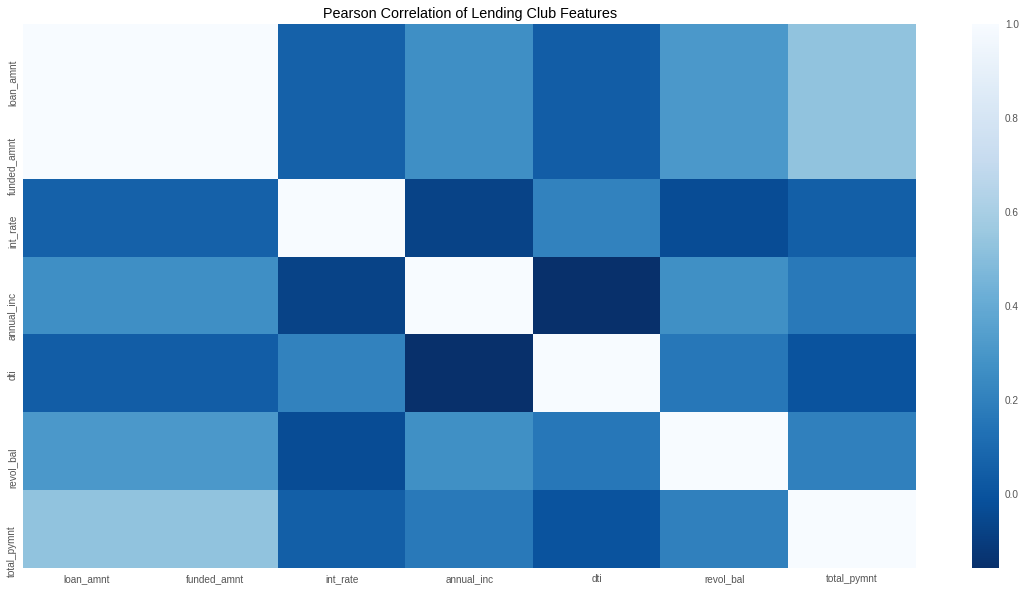

In [1399]:
plt.figure(figsize=(20,10))
plt.title('Pearson Correlation of Lending Club Features')
loan_data_correlations= loan_data.corr()
sns.heatmap(loan_data_correlations, cmap="Blues_r") 

In [1402]:
loan_data_correlations

,loan_amnt,funded_amnt,int_rate,annual_inc,dti,revol_bal,total_pymnt
loan_amnt,1.000000,0.999999,0.061564,0.264543,0.044270,0.308795,0.527382
funded_amnt,0.999999,1.000000,0.061566,0.264544,0.044269,0.308795,0.527381
int_rate,0.061564,0.061566,1.000000,-0.073078,0.206382,-0.032974,0.053164
annual_inc,0.264543,0.264544,-0.073078,1.000000,-0.156638,0.271714,0.165138
dti,0.044270,0.044269,0.206382,-0.156638,1.000000,0.161675,0.000868
revol_bal,0.308795,0.308795,-0.032974,0.271714,0.161675,1.000000,0.198207
total_pymnt,0.527382,0.527381,0.053164,0.165138,0.000868,0.198207,1.000000


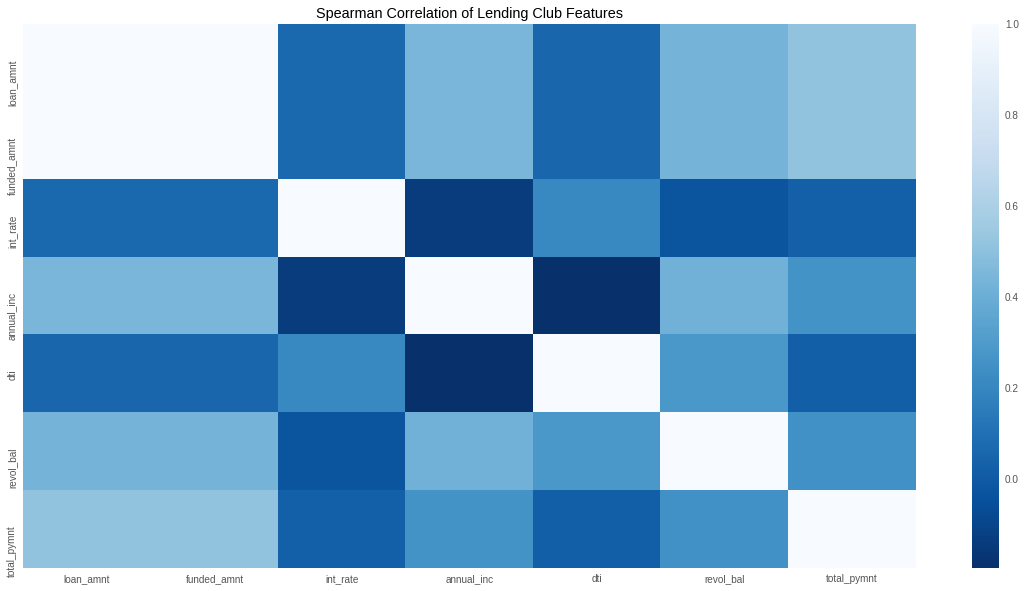

In [1400]:
plt.figure(figsize=(20,10))
plt.title('Spearman Correlation of Lending Club Features')
loan_data_correlations_spearman= loan_data.corr(method='spearman')
sns.heatmap(loan_data_correlations_spearman, cmap="Blues_r")

### Next Steps

Feature Distributions

• Evaluate various transformations of feature values and further processing of feature distributions. 

Feature Engineering

• Analyze and extract further insights within the dataset to create more valuable features (ex: sparse features).

• Improve feature representations to improve their usability within the model (using mis-calibration, truncation, bucketizing).

Feature Statistics

• Evaluate further statistics including positive label rate broken down across subsets of borrowers (and subsets of their characteristics), calibration, etc.

## Part 2: Business Analysis

Assume all loans are 36 month

In [1571]:
loan_data_36_months = loan_data

Filter data to loans with <36 months data available (defined as issue_d predating December 1, 2016)

In [1572]:
loan_data_36_months.issue_d.unique()

array(['Dec-2018', 'Nov-2018', 'Oct-2018', 'Sep-2018', 'Aug-2018',
       'Jul-2018', 'Jun-2018', 'May-2018', 'Apr-2018', 'Mar-2018',
       'Feb-2018', 'Jan-2018', 'Sep-2016', 'Aug-2016', 'Jul-2016',
       'Jun-2016', 'May-2016', 'Apr-2016', 'Mar-2016', 'Feb-2016',
       'Jan-2016', 'Dec-2016', 'Nov-2016', 'Oct-2016', 'Dec-2015'],
      dtype=object)

In [1573]:
dates_to_remove = ['Dec-2018', 'Nov-2018', 'Oct-2018', 'Sep-2018', 'Aug-2018',
       'Jul-2018', 'Jun-2018', 'May-2018', 'Apr-2018', 'Mar-2018',
       'Feb-2018', 'Jan-2018', 'Dec-2016']

In [1574]:
for date in dates_to_remove: 
    loan_data_36_months = loan_data_36_months[loan_data_36_months.issue_d!=date]

Filter was successful.

In [1578]:
loan_data_36_months.issue_d.unique()

array(['Sep-2016', 'Aug-2016', 'Jul-2016', 'Jun-2016', 'May-2016',
       'Apr-2016', 'Mar-2016', 'Feb-2016', 'Jan-2016', 'Nov-2016',
       'Oct-2016', 'Dec-2015'], dtype=object)

In [1576]:
print("The percentage of loans which have been fully paid are: ", 
      round((loan_data_36_months[
          loan_data_36_months['loan_status']=='Fully Paid'
      ]['loan_status'].count()/
             loan_data_36_months['loan_status'].count())*100, 2), 
     "%")

The percentage of loans which have been fully paid are:  50.13 %


Define a defaulted loans label as loans which have been fully paid.

In [1579]:
loan_data_36_months['default_label'] = np.where(loan_data_36_months['loan_status']=='Fully Paid', 0, 1)

Extract years from string column in order to group by years.

In [1580]:
loan_data_36_months['year'] = 0
loan_data_36_months = get_all_years(loan_data_36_months)
loan_data_36_months.head()

,loan_amnt,funded_amnt,term,int_rate,grade,annual_inc,issue_d,dti,revol_bal,total_pymnt,loan_status,default_label,year
495242,8000,8000,36 months,12.79,C,95000.0,Sep-2016,10.30,11343.0,7521.680000,Current,1,2016
495243,20000,20000,60 months,17.99,D,66000.0,Sep-2016,12.62,3565.0,7366.250000,Charged Off,1,2016
495244,10000,10000,36 months,8.59,A,137500.0,Sep-2016,13.42,9031.0,10962.479076,Fully Paid,0,2016
495245,32200,32200,60 months,21.49,D,65000.0,Sep-2016,11.71,11987.0,35770.812746,Fully Paid,0,2016
495246,2600,2600,36 months,8.99,B,35000.0,Sep-2016,6.73,720.0,2662.590238,Fully Paid,0,2016


Calculate rate of default by year and loan grade. 

In [1581]:
grade_r_sq = calculate_r_sq(loan_data_36_months, "grade")
print("The linear relationship between loan grade and default is: ", round(grade_r_sq*100, 2), "%")
print("The correlation between loan grade and default is: ", round(math.sqrt(grade_r_sq)*100, 2), "%")

The linear relationship between loan grade and default is:  1.95 %
The correlation between loan grade and default is:  13.96 %


In [1582]:
year_r_sq = calculate_r_sq(loan_data_36_months, "issue_d", 'default_label')
print("The linear relationship between loan issue date and default is: ", round(year_r_sq*100, 2), "%")
print("The correlation between loan issue date and default is: ", round(math.sqrt(year_r_sq)*100, 2), "%")

The linear relationship between loan issue date and default is:  4.05 %
The correlation between loan issue date and default is:  20.13 %


• As visualized, the rate of defaults is highest in this filtered dataset for the 2016 Grade G cohort with 64% default rate. Because loan grade is an indicator of borrower risk and loan quality, this matches intuition. 

• The linear relationship indicates a minimally stronger relationship (through correlation), R-squared is essentially not related) between issue date and default than loan grade and default.  In the below visualization, it is clear the rate of default increases in a similar pattern by loan grade risk for both years, but appears significantly different in comparing years.

In [1587]:
defaulted_ratio.sort_values('default_label', ascending=False)

,grade,year,default_label
13,G,2016,0.680626
11,F,2016,0.660550
12,G,2015,0.657895
9,E,2016,0.617916
10,F,2015,0.590106
7,D,2016,0.577368
8,E,2015,0.573239
5,C,2016,0.538448
3,B,2016,0.479927
6,D,2015,0.468406


In [1586]:
highest_cohort = defaulted_ratio.sort_values('default_label', ascending=False).iloc[0]
print("The cohort with the highest rate of defaults is:", "loan_grade", highest_cohort[0], "year", highest_cohort[1], "with rate", round(highest_cohort[2]*100, 2), "%")

The cohort with the highest rate of defaults is: loan_grade G year 2016 with rate 68.06 %


[Text(0,0.5,'Default Rate')]

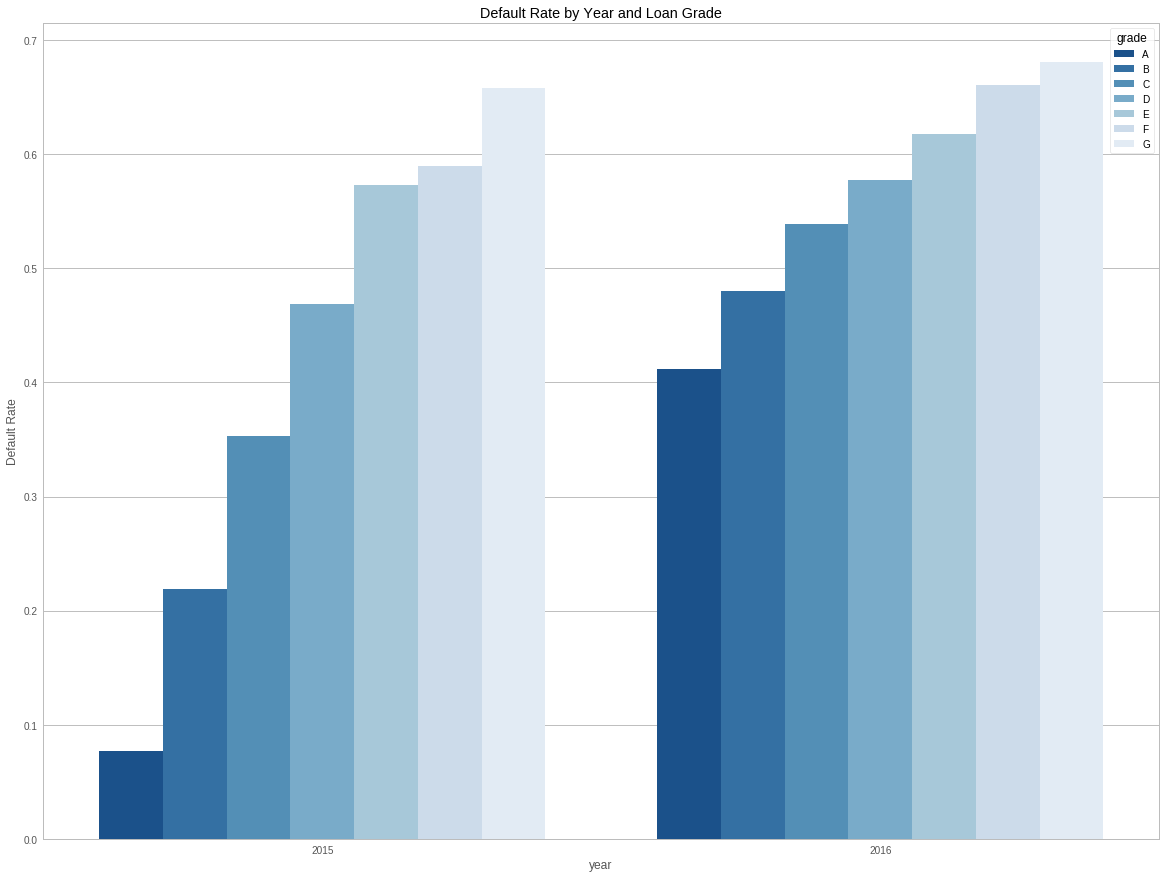

In [1588]:
plt.subplots(figsize=(20,15))
defaulted_loans = loan_data_36_months['default_label'].groupby([loan_data_36_months['grade'], loan_data_36_months['year']]).sum()
all_loans = loan_data_36_months['default_label'].groupby([loan_data_36_months['grade'], loan_data_36_months['year']]).count()
defaulted_ratio = pd.DataFrame(defaulted_loans/all_loans).reset_index()
plt.title('Default Rate by Year and Loan Grade')
sns.barplot(x='year', y='default_label', data=defaulted_ratio, hue='grade', palette="Blues_r").set(ylabel='Default Rate')

In [1589]:
loan_data_36_months_final = get_all_rors(loan_data_36_months)

In [1590]:
annualized_ror = annualized_ror.reset_index(level=0)

In [1591]:
annualized_ror

,grade,annualized_rate_of_return
year,,
2015,A,0.017316
2015,B,0.014486
2015,C,0.005289
2016,A,0.002727
2016,B,-0.001985
2015,D,-0.008131
2016,C,-0.008608
2016,D,-0.016383
2015,E,-0.026715


In [1592]:
annualized_ror = pd.DataFrame(loan_data_36_months_final['annualized_rate_of_return'].groupby([loan_data_36_months_final['grade'], loan_data_36_months_final['year']]).mean()).sort_values('annualized_rate_of_return', ascending=False)

In [1593]:
print("The average rate of return aggregated by loan grade and year is: ", round(annualized_ror.annualized_rate_of_return.mean(), 3)*100, "%")

The average rate of return aggregated by loan grade and year is:  -3.6999999999999997 %


• Average rate of return is negative across the entire portfolio of 36 month term loans at -3.7%.

• However, high grade bonds from A-C in 2015 and A in 2016 had positive average rate of return on average. The highest performing loan cohort was grade A in 2015, which is to be expected given it is the earliest lowest risk measured.

• Negatively performing bonds were lower in grade and newer. 

In [1596]:
loan_data_36_months_final.head()

,loan_amnt,funded_amnt,term,int_rate,grade,annual_inc,issue_d,dti,revol_bal,total_pymnt,loan_status,default_label,year,annualized_rate_of_return
495242,8000,8000,36 months,12.79,C,95000.0,Sep-2016,10.30,11343.0,7521.680000,Current,1,2016,-0.020341
495243,20000,20000,60 months,17.99,D,66000.0,Sep-2016,12.62,3565.0,7366.250000,Charged Off,1,2016,-0.283188
495244,10000,10000,36 months,8.59,A,137500.0,Sep-2016,13.42,9031.0,10962.479076,Fully Paid,0,2016,0.031105
495245,32200,32200,60 months,21.49,D,65000.0,Sep-2016,11.71,11987.0,35770.812746,Fully Paid,0,2016,0.035677
495246,2600,2600,36 months,8.99,B,35000.0,Sep-2016,6.73,720.0,2662.590238,Fully Paid,0,2016,0.007961


• In general, the variance and spread of the performance of the bond cohorts increases as the loan grade increases. 

• The earliest loans and higher grade bonds will have the highest average rate of return. 

• The lower grade bonds will have the widest spread and highest potential for upside and downside. 

• Grade C 2016 loans appears to be an outlier, with an exceptionally high spread of higher rate of return. 

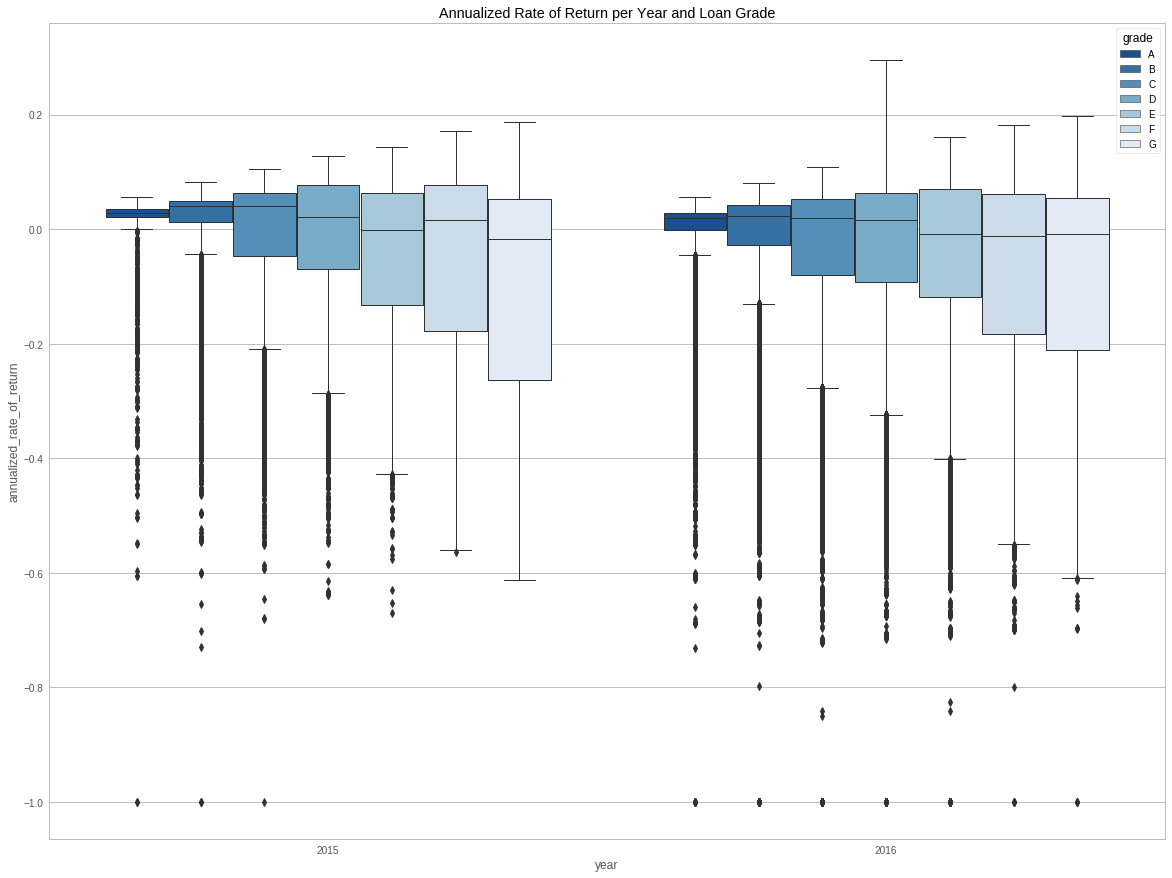

In [1597]:
plt.subplots(figsize=(20,15))
plt.title('Annualized Rate of Return per Year and Loan Grade')
sns.boxplot(x='year', 
            y='annualized_rate_of_return', 
            data=loan_data_36_months_final, 
            hue='grade', 
            hue_order=['A', 'B', 'C', 'D', 'E', 'F', 'G'],
            palette="Blues_r")

## Part 3: Modeling

### Label

Label defined above as those which have not been fully paid. 

In [1599]:
label=loan_data_36_months_final['default_label']

In [1600]:
label.count()

426363

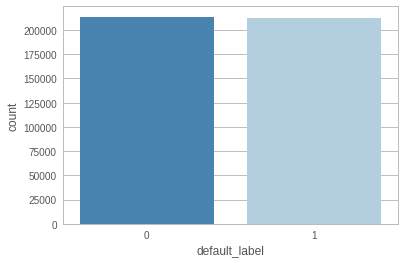

In [1601]:
sns.countplot(x=label, palette="Blues_r")

### Features

Extract relevant features available at origination. This does not include loan status (assumed to be current and used for label definition) or term (we assume all loans are 36 month).

In [1602]:
features = loan_data_36_months_final[['dti', 'annual_inc', 'int_rate', 'funded_amnt', 'grade', 'issue_d']]

In [1603]:
features.head()

,dti,annual_inc,int_rate,funded_amnt,grade,issue_d
495242,10.30,95000.0,12.79,8000,C,Sep-2016
495243,12.62,66000.0,17.99,20000,D,Sep-2016
495244,13.42,137500.0,8.59,10000,A,Sep-2016
495245,11.71,65000.0,21.49,32200,D,Sep-2016
495246,6.73,35000.0,8.99,2600,B,Sep-2016


Text Features: One Hot Encoding to convert features to a usable format for the model

In [1604]:
features = pd.get_dummies(features, columns=["grade", "issue_d"])

In [1605]:
features.head()

,dti,annual_inc,int_rate,funded_amnt,grade_A,grade_B,grade_C,grade_D,grade_E,grade_F,grade_G,issue_d_Apr-2016,issue_d_Aug-2016,issue_d_Dec-2015,issue_d_Feb-2016,issue_d_Jan-2016,issue_d_Jul-2016,issue_d_Jun-2016,issue_d_Mar-2016,issue_d_May-2016,issue_d_Nov-2016,issue_d_Oct-2016,issue_d_Sep-2016
495242,10.30,95000.0,12.79,8000,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
495243,12.62,66000.0,17.99,20000,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
495244,13.42,137500.0,8.59,10000,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
495245,11.71,65000.0,21.49,32200,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
495246,6.73,35000.0,8.99,2600,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


Splitting Historical Data into Training and Evaluation Datasets

In [1606]:
features_train, features_test, label_train, label_test = train_test_split(
    features, 
    label, 
    test_size=0.25, 
    random_state=0
)

Scale and Normalize Features

In [1607]:
sc_x = StandardScaler()
features_train = sc_x.fit_transform(features_train)  
features_test = sc_x.transform(features_test) 

Fit Model and Predict on Evaluation Dataset

In [1608]:
logreg = LogisticRegression(C=100, class_weight='balanced')
logreg.fit(features_train, label_train)

LogisticRegression(C=100, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)

In [1611]:
label_pred=logreg.predict(features_test)

Evaluation Metrics of Baseline Model

• Model accurately identifies 65% of defaulted loans (recall), which is effective but not well-performing. Because there is probably a higher business cost of having more inaccurately classified defaulted loans (false positives), it is important to have high recall. If we seek to maximize for identifying all default labels, optimizing for recall is most important.

• Of the identified default labels, only 58% are actually defaults. This indicates the model is only slightly better than random at distinguishing real default labels from false negatives.

• The F1 score, which measures the model's balance between precision and recall given both have business costs indicates the model is minimizing false negatives and false positives. 

• Model is not over/under-fit as RMSE of train and test groups nearly match.

In [1612]:
confusion_matrix = pd.crosstab(label_test, label_pred, rownames=['Actual'], colnames=['Predicted'])

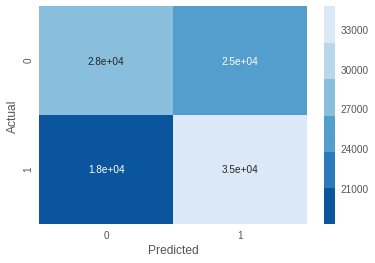

In [1613]:
sns.heatmap(confusion_matrix, annot=True, cmap=pal)

In [1614]:
print("Accuracy:", metrics.accuracy_score(label_test, label_pred))
print("Precision:", metrics.precision_score(label_test, label_pred))
print("Recall:", metrics.recall_score(label_test, label_pred))

Accuracy: 0.5923764670563181
Precision: 0.5798235225434104
Recall: 0.6556205205582799


In [1615]:
f1_score(label_test,label_pred)

0.6153968717635498

In [1616]:
print(classification_report(label_test,label_pred))

              precision    recall  f1-score   support

           0       0.61      0.53      0.57     53571
           1       0.58      0.66      0.62     53020

   micro avg       0.59      0.59      0.59    106591
   macro avg       0.59      0.59      0.59    106591
weighted avg       0.59      0.59      0.59    106591



Model is well-fit because RMSE on both train and test datasets are nearly the same.

In [1617]:
eval_rmse(label_pred, label_test)

0.6384540178773112

In [1618]:
label_pred_train=logreg.predict(features_train)

In [1619]:
eval_rmse(label_pred_train, label_train)

0.6366696047262091

### Next Steps

Evaluation Metrics

• Using k-fold cross validation would be ideal to ensure confidence in evaluation metrics.

• Increase suite of evaluation metrics to improve and build cohesive story. In particular, use AUC/ROC to further detail the model's ability to distinguish the two classes. Further, use the Gini index to understand model performance relative to random prediction. 

Feature Selection and Understanding

• Try both forward and backward feature selection to parameter tune model. 

• Evaluate different feature importance algorithms (ex: permutation, chi, kbest) for feature selection.

• Use LIME (local) or Shapley (global) as feature explainers to better understand the effect of each feature on predicting if a user will default. Evaluate over different cohorts. 

• Evaluate post-training feature correlation and evaluate removing correlated features for improved performance.

Model Type

• Fit other model types to evaluate the best model fit which most effectively classifies defaulted loans at origination time (especially linear regression for a baseline, GBDT and Random Forest, and Neural Network). 